In [3]:
import random
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt

class MemoryTier:
    def __init__(self, name, size, latency):
        self.name = name
        self.size = size
        self.latency = latency
        self.data = {}
        self.access_order = []

    def access(self, address):
        if address in self.data:
            if address in self.access_order:
                self.access_order.remove(address)
            self.access_order.append(address)
            return self.data[address], self.latency
        return None, self.latency

    def write(self, address, value):
        if len(self.data) >= self.size:
            evicted_address = self.access_order.pop(0)
            del self.data[evicted_address]
            print(f"Evicted address {evicted_address} from {self.name}")
        self.data[address] = value
        self.access_order.append(address)

class TieredMemorySystem:
    def __init__(self, dram_size, dram_latency, dram_bandwidth, nvm_size, nvm_latency, nvm_bandwidth):
        self.dram = MemoryTier("DRAM", dram_size, dram_latency)
        self.nvm = MemoryTier("NVM", nvm_size, nvm_latency)
        self.dram_bandwidth = dram_bandwidth
        self.nvm_bandwidth = nvm_bandwidth
        self.total_copy_time = 0
        self.total_migration_time = 0
        self.total_remap_time = 0
        self.migration_count = 0
        self.copy_count = 0

    def migrate_to_dram(self, address, value):
        try:
            # Simulate memory copying time
            data_size = 1024  # Assume 1 KB per page
            migration_time = data_size / (self.dram_bandwidth * 1024 / 1000)  # Time in ms
            remap_time = 0.05  # Fixed remapping time in ms
            self.total_migration_time += migration_time
            self.total_remap_time += remap_time
            self.migration_count += 1

            # Perform migration
            self.dram.write(address, value)
            del self.nvm.data[address]
            print(f"Migrated address {address} to DRAM (Migration Time: {migration_time:.2f} ms, Remap Time: {remap_time:.2f} ms).")
        except MemoryError:
            print("DRAM is full. Cannot migrate.")

    def copy_to_dram(self, address, value):
        # Simulate copying data to DRAM without migration
        data_size = 1024  # Assume 1 KB per page
        copy_time = data_size / (self.dram_bandwidth * 1024 / 1000)  # Time in ms
        self.total_copy_time += copy_time
        self.copy_count += 1
        
        # Perform copy
        self.dram.write(address, value)
        print(f"Copied address {address} to DRAM (Copy Time: {copy_time:.2f} ms).")

    def vectorized_copy_to_dram(self, address, value):
        # Simulate vectorized copy using numpy
        src_array = np.array([value])
        dst_array = np.array([0], dtype=src_array.dtype)
        dst_array[:] = src_array
        
        copy_time = len(str(value)) / (self.dram_bandwidth * 1024 / 1000)
        self.total_copy_time += copy_time
        
        # Perform copy
        self.dram.write(address, dst_array[0])
        print(f"Copied address {address} to DRAM (Copy Time: {copy_time:.2f} ms).")

    def prefetching_copy_to_dram(self, address, value):
        # Prefetch copy data from NVM to DRAM
        copy_time = len(str(value)) / (self.dram_bandwidth * 1024 / 1000)
        self.total_copy_time += copy_time
        
        # Perform copy
        self.dram.write(address, value)
        print(f"Copied address {address} to DRAM (Copy Time: {copy_time:.2f} ms).")

    def non_temporal_copy_to_dram(self, address, value):
        # Simulate non-temporal copy (conceptual)
        copy_time = len(str(value)) / (self.dram_bandwidth * 1024 / 1000)
        self.total_copy_time += copy_time
        
        # Perform copy
        self.dram.write(address, value)
        print(f"Copied address {address} to DRAM (Copy Time: {copy_time:.2f} ms).")

    def parallel_copy_to_dram(self, address, value):
        # Parallelize copy operation
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(self.parallel_copy_data, address, value)
            future.result()

    def parallel_copy_data(self, address, value):
        # Perform actual data copy
        copy_time = len(str(value)) / (self.dram_bandwidth * 1024 / 1000)
        self.total_copy_time += copy_time
        self.dram.write(address, value)
        print(f"Copied address {address} to DRAM (Copy Time: {copy_time:.2f} ms).")

    def dma_copy_to_dram(self, address, value):
        # Simulate DMA copy (conceptual)
        copy_time = len(str(value)) / (self.dram_bandwidth * 1024 / 1000)
        self.total_copy_time += copy_time
        
        # Perform copy
        self.dram.write(address, value)
        print(f"Copied address {address} to DRAM (Copy Time: {copy_time:.2f} ms).")

    def access_memory(self, address, value=None, write=False, copy_strategy=None):
        # Access DRAM first
        data, latency = self.dram.access(address)
        if data is not None:
            print(f"Address {address} found in DRAM. Latency: {latency} ms")
            return latency

        # Access NVM if not found in DRAM
        data, latency = self.nvm.access(address)
        if data is not None:
            print(f"Address {address} found in NVM. Latency: {latency} ms")
            if write:
                if copy_strategy == "vectorized":
                    self.vectorized_copy_to_dram(address, data)
                elif copy_strategy == "prefetching":
                    self.prefetching_copy_to_dram(address, data)
                elif copy_strategy == "non_temporal":
                    self.non_temporal_copy_to_dram(address, data)
                elif copy_strategy == "parallel":
                    self.parallel_copy_to_dram(address, data)
                elif copy_strategy == "dma":
                    self.dma_copy_to_dram(address, data)
                else:
                    self.copy_to_dram(address, data)
            return latency

        # If not found, write to NVM
        if write:
            print(f"Address {address} not found. Writing to NVM.")
            self.nvm.write(address, value)
        return latency

    def get_performance_metrics(self):
        return {
            "Total Copy Time (ms)": self.total_copy_time,
            "Total Migration Time (ms)": self.total_migration_time,
            "Total Remap Time (ms)": self.total_remap_time,
            "Total Migrations": self.migration_count,
            "Total Copies": self.copy_count,
        }



In [4]:
# Main function for testing
if __name__ == "__main__":
    tiered_memory = TieredMemorySystem(
        dram_size=10, 
        dram_latency=0.1, 
        dram_bandwidth=2400,  
        nvm_size=100, 
        nvm_latency=0.5, 
        nvm_bandwidth=128  
    )

    hot_addresses = [random.randint(0, 19) for _ in range(20)]
    copy_strategies = ["vectorized", "prefetching", "non_temporal", "parallel", "dma"]
    copy_times = []

    for strategy in copy_strategies:
        tiered_memory.total_copy_time = 0
        for _ in range(500):  
            if random.random() < 0.7:
                addr = random.choice(hot_addresses)  
            else:
                addr = random.randint(0, 99)
            tiered_memory.access_memory(addr, value=random.randint(0, 100), write=True, copy_strategy=strategy)
            tiered_memory.access_memory(addr)
        
        print(f"{strategy.capitalize()} Copy Time: {tiered_memory.total_copy_time:.2f} ms")
        copy_times.append(tiered_memory.total_copy_time)

Address 1 not found. Writing to NVM.
Address 1 found in NVM. Latency: 0.5 ms
Address 15 not found. Writing to NVM.
Address 15 found in NVM. Latency: 0.5 ms
Address 13 not found. Writing to NVM.
Address 13 found in NVM. Latency: 0.5 ms
Address 15 found in NVM. Latency: 0.5 ms
Copied address 15 to DRAM (Copy Time: 0.00 ms).
Address 15 found in DRAM. Latency: 0.1 ms
Address 15 found in DRAM. Latency: 0.1 ms
Address 15 found in DRAM. Latency: 0.1 ms
Address 5 not found. Writing to NVM.
Address 5 found in NVM. Latency: 0.5 ms
Address 7 not found. Writing to NVM.
Address 7 found in NVM. Latency: 0.5 ms
Address 98 not found. Writing to NVM.
Address 98 found in NVM. Latency: 0.5 ms
Address 13 found in NVM. Latency: 0.5 ms
Copied address 13 to DRAM (Copy Time: 0.00 ms).
Address 13 found in DRAM. Latency: 0.1 ms
Address 11 not found. Writing to NVM.
Address 11 found in NVM. Latency: 0.5 ms
Address 13 found in DRAM. Latency: 0.1 ms
Address 13 found in DRAM. Latency: 0.1 ms
Address 15 found in DRA

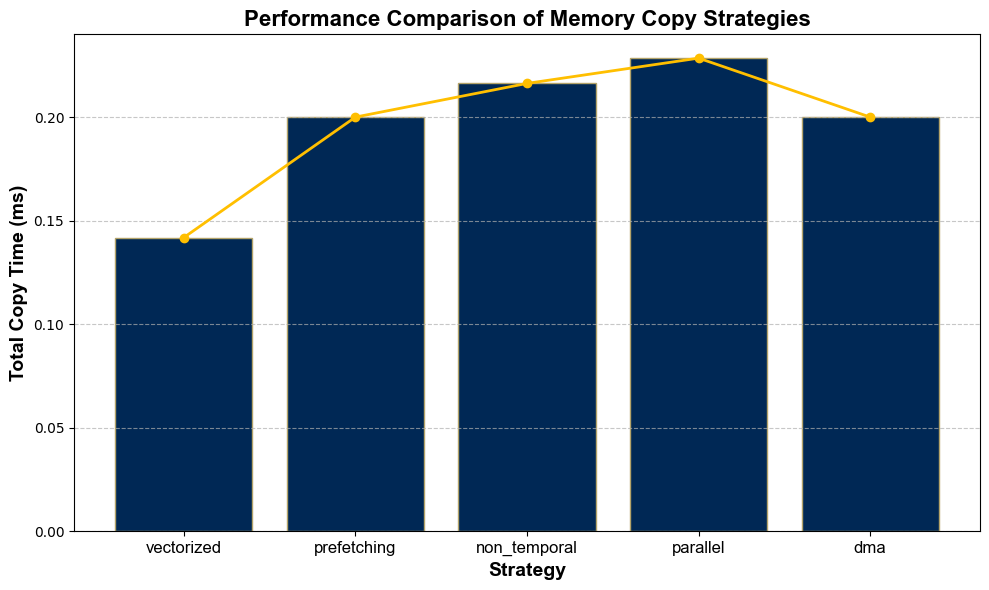

In [13]:
# Plotting performance
plt.figure(figsize=(10, 6))  # Increase figure size
plt.bar(copy_strategies, copy_times, color='#002855', edgecolor='#B3A369', linewidth=1)  # Use Yale Blue for bars with Gold edges
plt.plot(copy_strategies, copy_times, marker='o', linestyle='-', color='#FFBF00', linewidth=2)  # Use lighter Aggie Gold for the trend line
plt.xlabel('Strategy', fontsize=14, fontweight='bold', fontname='Arial')  # Increase font size and bold labels with Arial font
plt.ylabel('Total Copy Time (ms)', fontsize=14, fontweight='bold', fontname='Arial')
plt.title('Performance Comparison of Memory Copy Strategies', fontsize=16, fontweight='bold', fontname='Arial')  # Increase title font size and bold
plt.xticks(rotation=0, ha='center', fontsize=12, fontname='Arial')  # Place labels horizontally and center them with Arial font
plt.tight_layout()  # Ensure labels fit within the figure
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for easier comparison
plt.legend([], frameon=False)  # Remove legend if not needed
plt.show()
